In [359]:
import numpy as np
from scipy.sparse import csc_matrix, diags, block_diag
from scipy.sparse import eye as speye
from scipy.sparse.linalg import splu as superlu_factor

class DiffusionReaction(object):
    @classmethod
    def _uniform_grid(cls, grid_points):
        z = np.linspace(0., 1., grid_points)
        dz = z[1:] - z[:-1]
        return z, dz

    @classmethod
    def _clustered_grid(cls, grid_points, grid_cluster_point, grid_cluster_intensity=6.):

        if grid_cluster_intensity < 1.e-16:
            raise ValueError('cluster_coeff must be strictly positive! Given value: ' + str(grid_cluster_intensity))

        if grid_cluster_point < 0. or grid_cluster_point > 1.:
            raise ValueError('z_cluster must be between 0 and 1! Given value: ' + str(grid_cluster_point))

        z = np.linspace(0., 1., grid_points)
        zo = 1.0 / (2.0 * grid_cluster_intensity) * np.log(
            (1. + (np.exp(grid_cluster_intensity) - 1.) * grid_cluster_point) / (
                1. + (np.exp(-grid_cluster_intensity) - 1.) * grid_cluster_point))
        a = np.sinh(grid_cluster_intensity * zo)
        for i in range(grid_points):
            z[i] = grid_cluster_point / a * (np.sinh(grid_cluster_intensity * (z[i] - zo)) + a)
        z[-1] = 1.
        dz = z[1:] - z[:-1]
        return z, dz

    def __init__(self,
                 initial_conditions,
                 diffusion_coefficient,
                 source_term,
                 source_term_jacobian,
                 variable_names=None,
                 grid=None,
                 grid_points=None,
                 grid_type='uniform',
                 grid_cluster_intensity=2.,
                 grid_cluster_point=0.5):

        self._neq = len(initial_conditions)

        if variable_names is None:
            self._variable_names = []
            for i in range(self._neq):
                self._variable_names.append('variable ' + str(i))
        else:
            self._variable_names = variable_names

        if grid is not None:
            self._x = np.copy(grid)
            self._dx = self._x[1:] - self._x[:-1]
        else:
            if grid_type == 'uniform':
                self._x, self._dx = self._uniform_grid(grid_points)
            elif grid_type == 'clustered':
                if grid_cluster_point == 'stoichiometric':
                    grid_cluster_point = self._mechanism.stoich_mixture_fraction(self._fuel_stream, self._oxy_stream)
                self._x, self._dx = self._clustered_grid(grid_points, grid_cluster_point, grid_cluster_intensity)
            else:
                error_message = 'Bad grid_type argument'
                raise ValueError(error_message)

        self._nx = self._x.size
        self._ndof = self._neq * self._nx

        if callable(diffusion_coefficient):
            self._d = diffusion_coefficient(self._x)
        elif isinstance(diffusion_coefficient, np.ndarray):
            self._d = np.copy(diffusion_coefficient)
        elif isinstance(diffusion_coefficient, float):
            self._d = np.zeros_like(self._x) + diffusion_coefficient
        else:
            raise TypeError('Bad diffusion_coefficient argument')
        
        self._initial_state = np.zeros(self._ndof)
        for offset, initial_condition in enumerate(initial_conditions):
            if callable(initial_condition):
                self._initial_state[offset::self._neq] = initial_condition(self._x)
            else:
                self._initial_state[offset::self._neq] = initial_condition

        self._variable_scales = np.ones(self._ndof)

        self._source_term = source_term
        self._source_term_jacobian = source_term_jacobian

        self._lhs_inverse_operator = None
        self._I = csc_matrix(speye(self._ndof))

        dxt = self._dx[:-1] + self._dx[1:]
        self._major_coeffs = - 2. * self._d[1:-1] / (self._dx[:-1] * self._dx[1:])
        self._sub_coeffs = 2. * self._d[1:-1] / (dxt * self._dx[:-1])
        self._sup_coeffs = 2. * self._d[1:-1] / (dxt * self._dx[1:])
        
        majdiag = np.tile(self._major_coeffs, (self._neq, 1)).T.ravel()
        supdiag = np.tile(self._sup_coeffs, (self._neq, 1)).T.ravel()
#         subdiag = np.tile(np.hstack((self._sub_coeffs[1:], self._sub_coeffs[0])), (self._neq, 1)).T.ravel()
        subdiag = np.tile(self._sub_coeffs, (self._neq, 1)).T.ravel()
        
        self._diffop = csc_matrix(diags([np.hstack([np.zeros(self._neq), majdiag, np.zeros(self._neq)]), 
                                         np.hstack([np.zeros(self._neq), supdiag]), 
                                         np.hstack([subdiag, np.zeros(self._neq)])], 
                                        [0, self._neq, -self._neq]))

    @property
    def initial_state(self):
        return self._initial_state
    
    @property
    def variable_names(self):
        return self._variable_names
    
    @property
    def x(self):
        return self._x
    
    def right_hand_side(self, t, state):
        rhs = self._source_term(t, state) + self._diffop.dot(state)
        return rhs

    def jacobian(self, t, state):
        return self._source_term_jacobian(t, state) + self._diffop

    def setup_superlu(self, t, state, prefactor):
        jac = self.jacobian(t, state)
        self._lhs_inverse_operator = superlu_factor(prefactor * jac - self._I)

    def solve_superlu(self, residual):
        return self._lhs_inverse_operator.solve(residual), 1, True


$$
2\mathrm{A} + \mathrm{B} \to \mathrm{C} \\
2\mathrm{C} + \mathrm{B} \to 3\mathrm{C}
$$

In [360]:
def right_hand_side(t, c, k_ab, k_bc):
    rhs = np.zeros_like(c)
    c_a = c[0::4]
    c_b = c[1::4]
    c_c = c[2::4]
    q_1 = k_ab * c_a * c_a * c_b
    q_2 = k_bc * c_b * c_c * c_c
    rhs[0::4] = -2 * q_1
    rhs[1::4] = -q_1 - q_2
    rhs[2::4] = q_1 + q_2
    return rhs

def jacobian(t, c, k_ab, k_bc):
    c_a = c[0::4]
    c_b = c[1::4]
    c_c = c[2::4]
    dq1_ca = 2. * k_ab * c_b * c_a
    dq1_cb = k_ab * c_a * c_a
    dq1_cc = 0.
    dq2_ca = 0.
    dq2_cb = k_bc * c_c * c_c
    dq2_cc = 2. * k_bc * c_b * c_c
    
    karray = np.zeros((c.size // 4, 4, 4))
     
    karray[:, 0, 0] = -2. * dq1_ca
    karray[:, 0, 1] = -dq1_cb
    karray[:, 0, 2] = dq1_cc
    
    karray[:, 1, 0] = -dq1_ca - dq2_ca
    karray[:, 1, 1] = -dq1_cb - dq2_cb
    karray[:, 1, 2] = -dq1_cc - dq2_cc
    
    karray[:, 2, 0] = dq1_ca + dq2_ca
    karray[:, 2, 1] = dq1_cb + dq2_cb
    karray[:, 2, 2] = dq1_cc + dq2_cc
    
    kjac = block_diag(karray, format='csc')
    
    return kjac

In [361]:
from spitfire import ESDIRK64, SimpleNewtonSolver, PIController, odesolve

k_ab = 2.
k_bc = 100.

first_time_step = 1e-3
max_time_step = 1e0
transient_tolerance = 1.e-8
nonlinear_solve_tolerance=1.e-12

method = ESDIRK64(SimpleNewtonSolver(tolerance=nonlinear_solve_tolerance))

controller = PIController(first_step=first_time_step,
                          max_step=max_time_step,
                          target_error=transient_tolerance)

initial_conditions = [lambda x: 1. - np.heaviside(x - 0.20, 0.0), 
                      lambda x: np.heaviside(x - 0.10, 0.0) - 0.5 * np.heaviside(x - 0.8, 0.0), 
                      0.,
                      lambda x: 0.5 * np.heaviside(x - 0.8, 0.0)]

model = DiffusionReaction(initial_conditions=initial_conditions,
                          diffusion_coefficient=0.01,
                          source_term=lambda t, y: right_hand_side(t, y, k_ab, k_bc),
                          source_term_jacobian=lambda t, y: jacobian(t, y, k_ab, k_bc),
                          variable_names=['A', 'B', 'C', 'D'],
                          grid_points=256,
                          grid_type='clustered',
                          grid_cluster_intensity=1.,
                          grid_cluster_point=0.25)

t, q = odesolve(model.right_hand_side,
                model.initial_state,
                save_each_step=True,
                stop_at_steady=1e-4,
                linear_setup=model.setup_superlu,
                linear_solve=model.solve_superlu,
                step_size=controller,
                method=method,
                verbose=True,
                log_rate=40)


 2020-03-29 15:57 : Spitfire running case with method: ESDIRK64

|number of  | simulation | time step  | diff. eqn. | total cpu  | cput per |
|time steps | time (s)   | size (s)   | |residual| | time (s)   | step (ms)|
---------------------------------------------------------------------------|
| 40        | 1.96e-02   | 1.38e-03   | 8.40e+00   | 1.71e+00   | 4.27e+01 |
| 80        | 2.07e-01   | 3.43e-03   | 7.32e+00   | 3.51e+00   | 4.39e+01 |
| 120       | 3.06e-01   | 2.18e-03   | 1.18e+01   | 5.56e+00   | 4.64e+01 |
| 160       | 3.91e-01   | 2.10e-03   | 1.23e+01   | 7.51e+00   | 4.69e+01 |
| 200       | 4.74e-01   | 2.08e-03   | 1.24e+01   | 9.24e+00   | 4.62e+01 |
| 240       | 5.57e-01   | 2.08e-03   | 1.25e+01   | 1.14e+01   | 4.73e+01 |
| 280       | 6.40e-01   | 2.07e-03   | 1.24e+01   | 1.36e+01   | 4.85e+01 |
| 320       | 7.23e-01   | 2.12e-03   | 1.21e+01   | 1.58e+01   | 4.92e+01 |
| 360       | 8.10e-01   | 2.22e-03   | 1.14e+01   | 1.78e+01   | 4.94e+01 |
----------

<IPython.core.display.Javascript object>


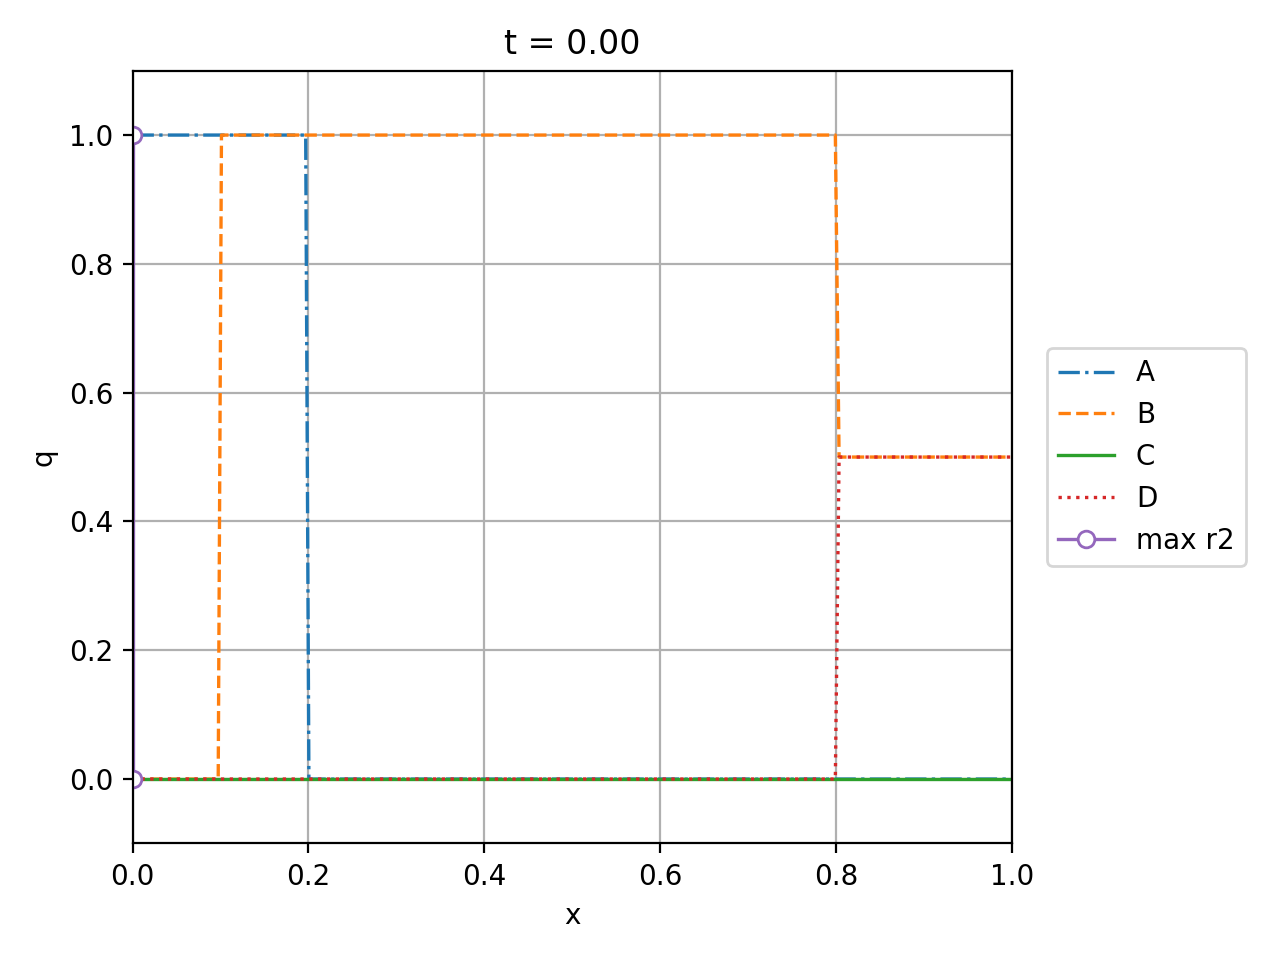

interactive(children=(IntSlider(value=0, description='it', max=670), Output()), _dom_classes=('widget-interact…

In [362]:
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets

rate2 = k_bc * q[:, 1::4] * q[:, 2::4] * q[:, 2::4]

%matplotlib notebook
l1, = plt.plot(model.x, q[0, 0::4], '-.', linewidth=1.2, label=model.variable_names[0])
l2, = plt.plot(model.x, q[0, 1::4], '--', linewidth=1.2,label=model.variable_names[1])
l3, = plt.plot(model.x, q[0, 2::4], '-', linewidth=1.2,label=model.variable_names[2])
l4, = plt.plot(model.x, q[0, 3::4], ':', linewidth=1.2,label=model.variable_names[3])
l5, = plt.plot(model.x[[np.argmax(rate2[0, :]), np.argmax(rate2[0, :])]], 
               [0, 1], '-o', 
               markerfacecolor='w', linewidth=1.2, label='max r2')
plt.xlim([model.x[0], model.x[-1]])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('x')
plt.ylabel('q')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.title(f't = {t[0]:.2f}')
plt.tight_layout()

def f(it):
    plt.title(f't = {t[it]:.2f}')
    l1.set_ydata(q[it, 0::4])
    l2.set_ydata(q[it, 1::4])
    l3.set_ydata(q[it, 2::4])
    l4.set_ydata(q[it, 3::4])
    l5.set_xdata(model.x[[np.argmax(rate2[it, :]), np.argmax(rate2[it, :])]])

interact(f, it=widgets.IntSlider(min=0, max=t.size-1, step=1, value=0));

$$
2\mathrm{A} + \mathrm{B} \to \mathrm{C} \\
2\mathrm{C} + \mathrm{B} \to 3\mathrm{C}
$$